In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

from scipy.signal import convolve2d
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

### Свёрточный классификатор

In [3]:
class ConvClassifier(nn.Module):
    
    def __init__(self, hidden_channels=[32, 128], lr=1e-4, l2=0.):
        super(ConvClassifier, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=hidden_channels[0],
            kernel_size=3
        )
        self.bn1 = nn.BatchNorm2d(num_features=hidden_channels[0])
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride=2,
            return_indices=False
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=hidden_channels[0],
            out_channels=hidden_channels[1],
            kernel_size=4
        )
        self.bn2 = nn.BatchNorm2d(num_features=hidden_channels[1])
        self.pool2 = nn.MaxPool2d(
            kernel_size=10,
            stride=1,
            return_indices=False
        )
        self.flat = nn.Flatten()
        self.fc = nn.Linear(in_features=128, out_features=10)
        self.act2 = nn.ReLU()

        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)        
    
    def forward(self, x):
        x = self.bn1(self.conv1(x)) # 32x26x26
        x = self.pool1(self.act1(x)) # 32x13x13               
        x = self.bn2(self.conv2(x)) # 128x10x10
        x = self.pool2(self.act2(x)) # global max pooling
        x = self.flat(x) # 128
        x = self.fc(x) # 10
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def optimize_data(images, weights):
    images = images.clone()
    for image_idx in range(images.shape[0]):        
        weight_idx = np.random.randint(weights.shape[0])
        images[image_idx][0] = torch.Tensor(convolve2d(images[image_idx][0], weights[weight_idx][0], mode='same'))
    return images                    

In [5]:
def train_classifier(epoch, model, conv_masks=None, log=None):
    train_size = len(train_loader.sampler)
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):        
        model.optim.zero_grad()
        if conv_masks is not None:
            data = optimize_data(data, conv_masks)
        output = model(data)
        loss = model.loss(output, target)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        loss.backward()
        model.optim.step()
            
        if batch_idx % 150 == 0:
            line = f'Train epoch {epoch} [{batch_idx * len(data):05d}/{train_size}] '
            loss = f'\tloss: {model._loss.item():.6f}'
            print(line + loss)
            
    else:
        batch_idx += 1
        line = f'Train epoch {epoch} [{batch_idx * len(data):05d}/{train_size}] '
        loss = f'\tloss: {model._loss.item():.6f}'
        if log is not None:
            log.append(model._loss)
        print(line + loss)

    train_accuracy = float(correct) / len(train_loader.dataset)
    line = f'\tTrain accuracy: {train_accuracy}'    
    print(line)

In [6]:
cl_avg_lambda = lambda l: f'loss: {l:.4f}'
cl_acc_lambda = lambda c, p: f'accuracy: {c}/{len(test_loader.dataset)} ({p:.0f}%)'
cl_line = lambda l, c, p: cl_avg_lambda(l) + '\t' + cl_acc_lambda(c, p)

def test_classifier(model, loader, conv_masks=None, log=None):
    test_loss = 0
    correct = 0
    test_size = len(loader.sampler)
    with torch.no_grad():
        for data, target in test_loader:
            if conv_masks is not None:
                data = optimize_data(data, conv_masks)            
            output = model(data)
            test_loss += model.loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum()                
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = float(correct) / len(test_loader.dataset)
    line = cl_line(test_loss, correct, test_accuracy*100)
    report = '\tTest set:' + line
    print(report,'\n')

In [7]:
classifier_32_128 = ConvClassifier(hidden_channels=[32,128])
train_log = []
test_log = []

In [11]:
for epoch in range(1, 11):
    classifier_32_128.train()
    train_classifier(epoch, classifier_32_128, conv_masks=None, log=train_log)
    classifier_32_128.eval()
    test_classifier(classifier_32_128, test_loader, conv_masks=None, log=test_log)

Train epoch 1 [00000/60000] 	loss: 3.137794
Train epoch 1 [30000/60000] 	loss: 1.058355
Train epoch 1 [60000/60000] 	loss: 0.621188
	Train accuracy: 0.77715
	Test set:loss: 0.5822	accuracy: 9341/10000 (93%) 

Train epoch 2 [00000/60000] 	loss: 0.594300
Train epoch 2 [30000/60000] 	loss: 0.378398
Train epoch 2 [60000/60000] 	loss: 0.339928
	Train accuracy: 0.9415
	Test set:loss: 0.2936	accuracy: 9590/10000 (96%) 

Train epoch 3 [00000/60000] 	loss: 0.308000
Train epoch 3 [30000/60000] 	loss: 0.262566
Train epoch 3 [60000/60000] 	loss: 0.224641
	Train accuracy: 0.9613
	Test set:loss: 0.1978	accuracy: 9714/10000 (97%) 

Train epoch 4 [00000/60000] 	loss: 0.238630
Train epoch 4 [30000/60000] 	loss: 0.176322
Train epoch 4 [60000/60000] 	loss: 0.121208
	Train accuracy: 0.9711833333333333
	Test set:loss: 0.1510	accuracy: 9750/10000 (98%) 

Train epoch 5 [00000/60000] 	loss: 0.100787
Train epoch 5 [30000/60000] 	loss: 0.165119
Train epoch 5 [60000/60000] 	loss: 0.143086
	Train accuracy: 0.9765

In [12]:
weight_to_plot = classifier_32_128.conv1.weight.data.numpy()
weight_to_plot.shape

(32, 1, 3, 3)

### Визуализация весов первого свёрточного слоя классификатора

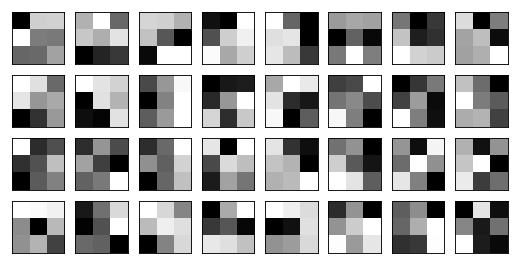

In [13]:
plot_mnist(weight_to_plot, (4, 8))

In [14]:
data, labels = next(iter(test_loader))

In [15]:
optimized_images = optimize_data(data, weight_to_plot)

### Применение фильтров свёртки к исходным изабражениям.
### Результат - "повышение чёткости" за счёт повышения контраста границ символов

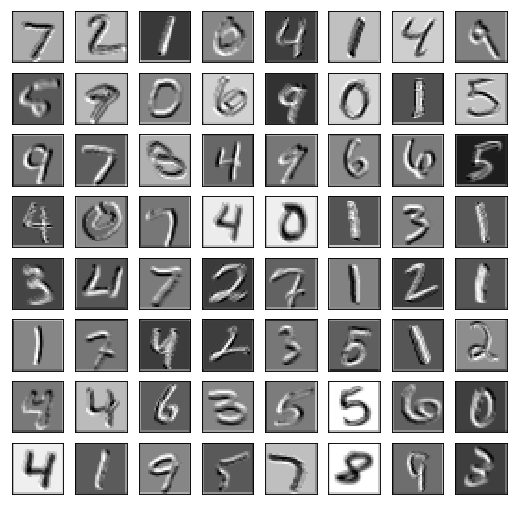

In [16]:
plot_mnist(optimized_images[:64], (8,8))

### Свёрточные кодировщик и декодировщик

In [51]:
class Encoder(nn.Module):
    def __init__(self, hidden_channels=[32, 1]):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=hidden_channels[0],
            kernel_size=3
        )
        self.bn1 = nn.BatchNorm2d(num_features=hidden_channels[0])
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride=2,
            return_indices=True
        )
        self.conv2 = nn.Conv2d(
            in_channels=hidden_channels[0],
            out_channels=hidden_channels[1],
            kernel_size=4
        )
        self.bn2 = nn.BatchNorm2d(num_features=hidden_channels[1])
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(
            kernel_size=2,
            stride=2,
            return_indices=True
        )
        
    
    def forward(self, x):
        x = self.bn1(self.conv1(x)) # 32x26x26
        x, indices1 = self.pool1(self.act1(x)) # 32x13x13                
        x = self.bn2(self.conv2(x)) # 1x10x10
        x, indices2 = self.pool2(self.act2(x)) #1x5x5
        
        return x, [indices2, indices1]
    
class Decoder(nn.Module):
    def __init__(self, hidden_channels=[1, 32]):
        super(Decoder, self).__init__()
        self.unpool1 = nn.MaxUnpool2d(
            kernel_size=2,
            stride=2
        )
        self.deconv1 = nn.ConvTranspose2d(
            in_channels=hidden_channels[0],
            out_channels=hidden_channels[1],
            kernel_size=4
        )
        self.unpool2 = nn.MaxUnpool2d(
            kernel_size=2,
            stride=2
        )
        self.deconv2 = nn.ConvTranspose2d(
            in_channels=hidden_channels[1],
            out_channels=1,
            kernel_size=3
        )
    
    def forward(self, x, indices):
        x = self.deconv1(self.unpool1(x, indices[0]))
        x = self.deconv2(self.unpool2(x, indices[1]))
        x = torch.tanh(x)
        return x

### Класс автокодировщика

In [52]:
class ConvAutoencoder(nn.Module):
    def __init__(self, hidden_channels=[32, 1], loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(ConvAutoencoder, self).__init__()
        self.E = Encoder(hidden_channels)
        self.D = Decoder(hidden_channels[::-1])
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):        
        h, indices = self.E(x)        
        out = self.D(h, indices)
        return out
    
    def encode(self, x):
        with torch.no_grad():
            return self.E(x)

    def decode(self, h, indices):
        with torch.no_grad():
            return self.D(h, indices)
    
    def loss(self, x, target, **kwargs):        
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [53]:
def train_autoencoder(epoch, model, log=None):        
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, data)
        loss.backward()
        model.optim.step()
            
        if batch_idx % 150 == 0:
            line = f'Train Epoch: {epoch} [{batch_idx * len(data):05d}/{train_size}] '
            loss = f'{model._loss.item():.6f}'
            print(line + loss)
            
    else:
        batch_idx += 1
        line = f'Train Epoch: {epoch} [{batch_idx * len(data):05d}/{train_size}] '
        loss = f'{model._loss.item():.6f}'
        if log is not None:
            log.append(model._loss)        
        print(line + loss)

In [54]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
    
def test_autoencoder(model, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = 0.
    with torch.no_grad():
        for data, _ in loader:            
            output = model(data)            
            test_loss += model.loss(output, data, reduction='sum').item() # sum up batch loss
    
    test_loss /= (test_size * 784)
    if log is not None:
        log.append(test_loss)
    
    lines = avg_lambda(test_loss) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [55]:
autoencoder_32_1 = ConvAutoencoder(hidden_channels=[32, 1])
train_log = []
test_log = []

In [56]:
for epoch in range(1, 11):
    autoencoder_32_1.train()
    train_autoencoder(epoch, autoencoder_32_1, train_log)
    autoencoder_32_1.eval()
    test_autoencoder(autoencoder_32_1, test_loader, test_log)

Train Epoch: 1 [00000/60000] 0.610582
Train Epoch: 1 [30000/60000] 0.490052
Train Epoch: 1 [60000/60000] 0.414765
Test set:
loss: 0.4197

Train Epoch: 2 [00000/60000] 0.413467
Train Epoch: 2 [30000/60000] 0.371583
Train Epoch: 2 [60000/60000] 0.351609
Test set:
loss: 0.3612

Train Epoch: 3 [00000/60000] 0.345739
Train Epoch: 3 [30000/60000] 0.329153
Train Epoch: 3 [60000/60000] 0.317587
Test set:
loss: 0.3195

Train Epoch: 4 [00000/60000] 0.318196
Train Epoch: 4 [30000/60000] 0.291030
Train Epoch: 4 [60000/60000] 0.274740
Test set:
loss: 0.2871

Train Epoch: 5 [00000/60000] 0.284128
Train Epoch: 5 [30000/60000] 0.261364
Train Epoch: 5 [60000/60000] 0.250784
Test set:
loss: 0.2547

Train Epoch: 6 [00000/60000] 0.251517
Train Epoch: 6 [30000/60000] 0.230215
Train Epoch: 6 [60000/60000] 0.201302
Test set:
loss: 0.2075

Train Epoch: 7 [00000/60000] 0.207416
Train Epoch: 7 [30000/60000] 0.157257
Train Epoch: 7 [60000/60000] 0.125822
Test set:
loss: 0.1237

Train Epoch: 8 [00000/60000] 0.126

In [57]:
data, labels = next(iter(test_loader))
output = autoencoder_32_1(data[100:150])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

### Результат обработки свёрточным автокодировщиком с двумя слоями (32 и 1 канал).
### Внутреннее представление - 5x5 вместо исходных 28x28.

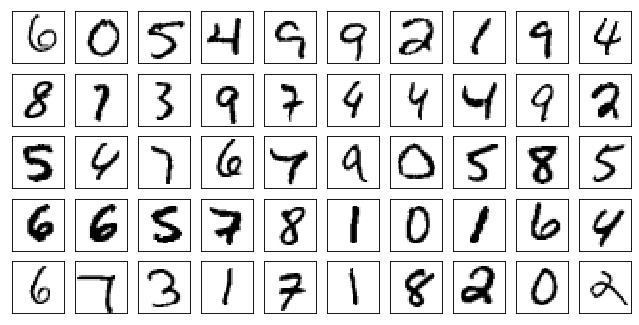

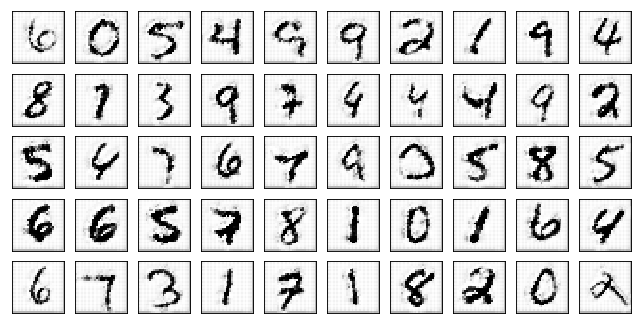

In [58]:
plot_mnist(data.data.numpy()[100:150], (5, 10))
plot_mnist(to_plot, (5, 10))

In [60]:
weight_to_plot = autoencoder_32_1.E.conv1.weight.data.numpy()
weight_to_plot.shape

(32, 1, 3, 3)

### Визуализация весов первого свёрточного слоя автокодировщика

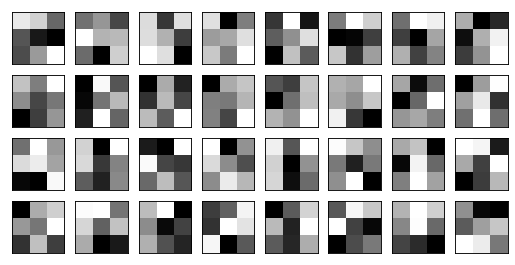

In [61]:
plot_mnist(weight_to_plot, (4, 8))

In [62]:
data, labels = next(iter(test_loader))

In [68]:
encoded_images, _ = autoencoder_32_1.encode(data)

In [69]:
encoded_images.shape

torch.Size([200, 1, 5, 5])

### Визуализация внутренних представлений символов а автокодировщике.
### Угадываются очертания исходных изображений.

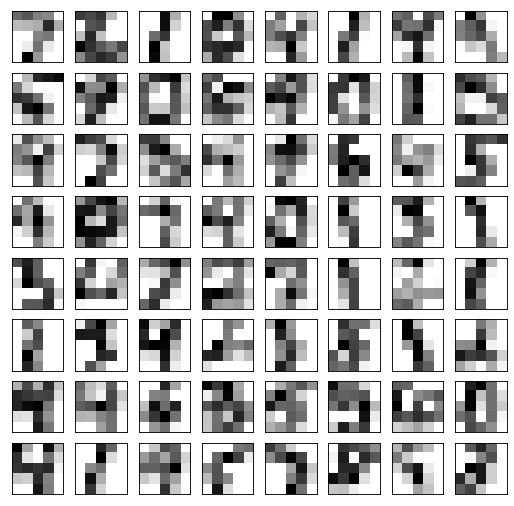

In [70]:
plot_mnist(encoded_images[:64], (8,8))

In [63]:
optimized_images = optimize_data(data, weight_to_plot)

### Применение фильтров свёртки к исходным изабражениям.

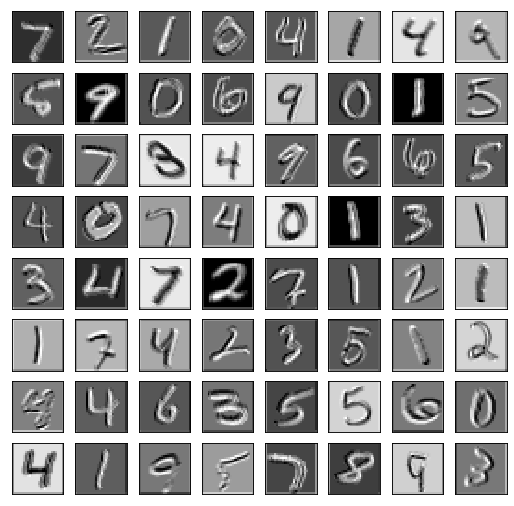

In [64]:
plot_mnist(optimized_images[:64], (8,8))